## Introduction

*Transfer learning* allows us to take the weights of another pre-trained model, and use them for our own problem.

For example, we can take the patterns of a CV model from datasets such as
*ImageNet* and use them to power our Food101 Mini model.

In [60]:
import torch
from torch import nn

import torchvision
from torchvision import transforms

from torchinfo import summary

In [61]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [62]:
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

before using a pretrained model we need a specific transforms

1. Manual Creation

In [63]:
manual_transforms = transforms.Compose(
    [
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[
                0.485,
                0.456,
                0.406,
            ],  # mean of [0.485, 0.456, 0.406] (across each colour channel)
            std=[0.229, 0.224, 0.225],
        ),  # standard deviation
    ]
)

In [64]:
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

train_dir = image_path / "train"
data_path = Path("data/")
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir, test_dir=test_dir, transform=manual_transforms, batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x73ce070ed0c0>,
 ['pizza', 'steak', 'sushi'])

## Getting a pre-trained model

In [65]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [66]:
summary(
    model=model,
    input_size=(32, 3, 244, 244),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 244, 244]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 244, 244]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 244, 244]    [32, 32, 122, 122]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 244, 244]    [32, 32, 122, 122]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 122, 122]   [32, 32, 122, 122]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 122, 122]   [32, 32, 122, 122]   --                   --
│    └─Sequential (1)                                        [32, 32, 122, 122]   [32, 16, 122

if we look at the summary we see lots and lots of layers
we can split it into three main parts:

1. features/features extractor => part of the model that learns the base representation of the data.
2. avgpool => takes the average of the features layers and turns it into a feature vector
3. classifier => turns the feature vector into a vector with the same dim as the number of required output.

But our model only needs 3 output layers not 1000,
so we need to freeze some base layers and adjust the classifier to suit our model.

> freezing layers means to keep them not trainable. i.e keep them how they are with their pre-trained values.

In [67]:
# we can freeze all features layers using requires_grad = False

for param in model.features.parameters():
    param.requires_grad = False

In [68]:
# to adjust the classifier
# we will create a new layers with the same dropout layer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=output_shape, bias=True).to(device),
)

In [69]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(
    model,
    input_size=(
        32,
        3,
        224,
        224,
    ),  # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

And now we have the same output size as our class_names and 
all the features layers are frozen  Notice how the trainable params dropped.

In [70]:
loss_fn = nn.CrossEntropyLoss()
optimized = torch.optim.Adam(params=model.parameters(), 
                             lr=0.0005,
                             weight_decay=5e-4)

In [71]:
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimized,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0660 | train_acc: 0.3516 | test_loss: 0.9804 | test_acc: 0.4773
Epoch: 2 | train_loss: 1.0187 | train_acc: 0.5312 | test_loss: 0.8679 | test_acc: 0.7822
Epoch: 3 | train_loss: 0.8912 | train_acc: 0.7734 | test_loss: 0.8307 | test_acc: 0.8655
Epoch: 4 | train_loss: 0.8663 | train_acc: 0.7266 | test_loss: 0.7668 | test_acc: 0.8447
Epoch: 5 | train_loss: 0.8061 | train_acc: 0.7344 | test_loss: 0.7476 | test_acc: 0.8551
Epoch: 6 | train_loss: 0.7733 | train_acc: 0.7656 | test_loss: 0.7473 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.7207 | train_acc: 0.7969 | test_loss: 0.6803 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.6892 | train_acc: 0.7852 | test_loss: 0.6481 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.6602 | train_acc: 0.7969 | test_loss: 0.6313 | test_acc: 0.8759
Epoch: 10 | train_loss: 0.6061 | train_acc: 0.9492 | test_loss: 0.6304 | test_acc: 0.8655
Epoch: 11 | train_loss: 0.6045 | train_acc: 0.8672 | test_loss: 0.6168 | test_acc: 0.8968
Epoch: 12 | train_l

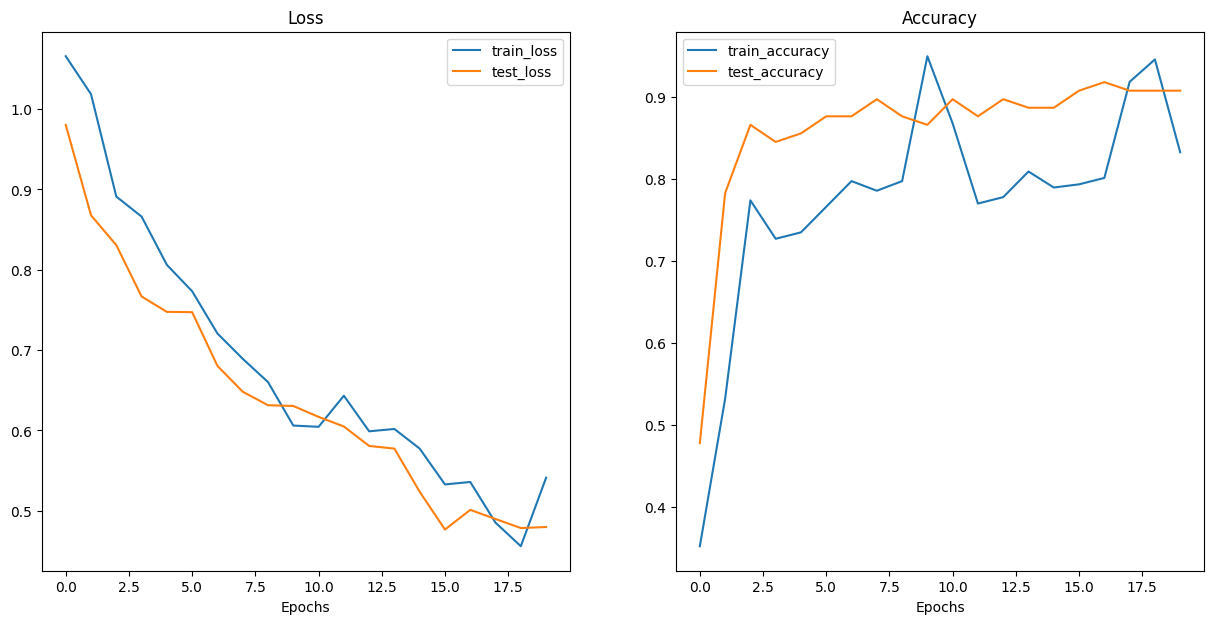

In [72]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [77]:
from typing import List, Tuple
import matplotlib.pyplot as plt


from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

data/04-pizza-dad.jpeg already exists, skipping download.


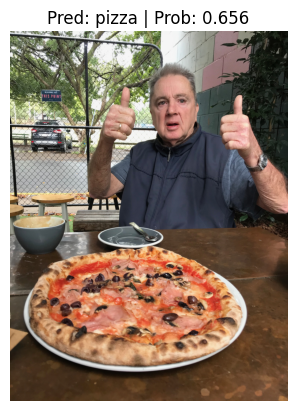

In [78]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

### Fine Tuning vs Feature Extraction

![Fine Tuning](../imgs/finetuning_feature.png)